In [1]:
from netCDF4 import Dataset
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2025-08-20 10:37:22.951742: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-20 10:37:22.952201: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-20 10:37:22.998897: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-20 10:37:24.139620: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

In [2]:
grid = Dataset("rotating-ellipse-20x8x20.fci.nc", "r")

MXG = int(grid.variables["MXG"].getValue())
n_total = int(grid.variables["total_cells"].getValue()) # Number of cells, including boundary cells
cell_number = grid.variables["cell_number"][:]
cell_number_forward = grid.variables["forward_cell_number"][:]
cell_number_backward = grid.variables["backward_cell_number"][:]

forward = {'ncells': n_total,
           'weights': grid.variables["forward_weights"][:],
           'rows': grid.variables["forward_rows"][:],
           'columns': grid.variables["forward_columns"][:]}

backward = {'ncells': n_total,
           'weights': grid.variables["backward_weights"][:],
           'rows': grid.variables["backward_rows"][:],
           'columns': grid.variables["backward_columns"][:]}

#J = grid.variables["J"][:]
#dx = grid.variables["dx"][:]
#dx = grid.variables["dx"][:]
#dz = grid.variables["dz"][:]
#dV = J * dx * dy * dz

grid.close()

n_evolving = len(forward['rows'])    # Number of time-evolving cells

In [3]:
volume = tf.ones(n_total, dtype=tf.dtypes.float64)  # Volume of each cell, including boundary cells

2025-08-20 10:37:29.694573: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


# Boundary conditions



In [4]:
nx, ny, nz = cell_number.shape

# Iterate over inner boundary
boundary_xinner = []
for i in range(MXG):
    for j in range(ny):
        for k in range(nz):
            # Pair of indices: First is the boundary, second is the point inside the domain
            boundary_xinner.append([cell_number[i, j, k], cell_number[MXG, j, k]])

# Outer boundary
boundary_xouter = []
for i in range(nx - MXG, nx):
    for j in range(ny):
        for k in range(nz):
            # Pair of indices: First is the boundary, second is the point inside the domain
            boundary_xouter.append([cell_number[i, j, k], cell_number[nx - MXG - 1, j, k]])

# Yforward
boundary_yforward = []
for i in range(MXG, nx - MXG):
    for j in range(ny):
        for k in range(nz):
            if cell_number_forward[i, j, k] > 0:
                boundary_yforward.append([cell_number_forward[i, j, k], cell_number[i, j, k]])

# Ybackward
boundary_ybackward = []
for i in range(MXG, nx - MXG):
    for j in range(ny):
        for k in range(nz):
            if cell_number_backward[i, j, k] > 0:
                boundary_ybackward.append([cell_number_backward[i, j, k], cell_number[i, j, k]])

print(f"Boundary points xinner {len(boundary_xinner)}, xouter {len(boundary_xouter)}, yforward {len(boundary_yforward)}, ybackward {len(boundary_ybackward)}")
n_boundary = len(boundary_xinner) + len(boundary_xouter) + len(boundary_yforward) + len(boundary_ybackward)

print(f"Cells: n_evolving {n_evolving} n_boundary {n_boundary} total {n_evolving + n_boundary} (check: {n_total})")

Boundary points xinner 320, xouter 320, yforward 607, ybackward 604
Cells: n_evolving 2560 n_boundary 1851 total 4411 (check: 4411)


In [5]:
boundary_xinner = tf.constant(boundary_xinner, dtype=tf.int64)
boundary_xouter = tf.constant(boundary_xouter, dtype=tf.int64)

boundary_yforward = tf.constant(boundary_yforward, dtype=tf.int64)
boundary_ybackward = tf.constant(boundary_ybackward, dtype=tf.int64)

In [6]:
# Operator to add boundary rows. This is a non-square matrix [n_total, n_evolving]

add_boundaries_op = tf.sparse.eye(n_total, num_columns = n_evolving, dtype=tf.dtypes.float64)

add_dirichlet_boundaries_op = tf.sparse.reorder(tf.sparse.SparseTensor(
    tf.concat([add_boundaries_op.indices,
               boundary_xinner,
               boundary_xouter,
               boundary_yforward,
               boundary_ybackward], axis=0),
    tf.concat([add_boundaries_op.values,
               tf.ones(n_boundary, dtype=tf.dtypes.float64) * -1], axis=0),
    add_boundaries_op.dense_shape))
               
add_neumann_boundaries_op = tf.sparse.reorder(tf.sparse.SparseTensor(
    tf.concat([add_boundaries_op.indices,
               boundary_xinner,
               boundary_xouter,
               boundary_yforward,
               boundary_ybackward], axis=0),
    tf.concat([add_boundaries_op.values,
               tf.ones(n_boundary, dtype=tf.dtypes.float64)], axis=0),
    add_boundaries_op.dense_shape))

In [7]:
# Operator to discard boundary rows

discard_boundaries = tf.sparse.eye(n_evolving, num_columns=n_total, dtype=tf.dtypes.float64)

# Forward and backward interpolation operators

In [8]:
def create_operator(csr):
    """
    csr has keys "ncells", "weights", "rows" and "columns"

    https://www.tensorflow.org/guide/sparse_tensor

    # Returns
    
    A tf.sparse.SparseTensor that is non-square [n_evolving, n_total]
     - Number of rows is the number of evolving cells
     - Number of columns is the total number of cells (evolving + boundary)
    """
    ncells = csr['ncells']
    rows = csr['rows']
    columns = csr['columns']
    weights = csr['weights']
    
    indices = []
    values = []
    dense_shape = [len(rows), ncells]

    for i in range(len(rows)):
        # Get the range of indices into the weights and columns arrays
        jstart = rows[i]
        if i == len(rows) - 1:
            jend = len(weights)
        else:
            jend = rows[i+1]
        for j in range(jstart, jend):
            indices.append([i, columns[j]])
            values.append(weights[j])

    return tf.sparse.SparseTensor(indices=tf.constant(indices, dtype=tf.int64),
                                  values=values,
                                  dense_shape=dense_shape)
    

In [9]:
forward_op = create_operator(forward)
backward_op = create_operator(backward)

# Parallel gradient operator

The gradient operator is a matrix $G$ such that the value of the gradient in cell $i$ of a field $f$ is 
$$
    \left(\nabla f\right)_i = \sum_j G_{ij} f_j
$$

- Points inside the domain are calculated using central differences: forward - backward
- Parallel boundary points calculated using one-sided differences
- Radial boundaries not modified



In [10]:
# Scaling a sparse tensor is a sonewhat convoluted process
minus_backward_op = tf.sparse.SparseTensor(backward_op.indices,
                                            tf.negative(backward_op.values), # Negate values
                                            backward_op.dense_shape)

In [11]:
# Operator with n_evolving rows
grad_par_op = tf.sparse.add(forward_op,
                             minus_backward_op)

#tf.sparse.to_dense(tf.sparse.reorder(backward_op))

# Add rows for the radial (X) and parallel (Y) boundaries
# to create a square n_total x n_total matrix
grad_par_op = tf.sparse.SparseTensor(tf.concat([grad_par_op.indices,
                                                # X boundaries unchanged - ones on the diagonal
                                                tf.tile(boundary_xinner[:, 0][...,tf.newaxis], multiples=[1,2]),
                                                tf.tile(boundary_xouter[:, 0][...,tf.newaxis], multiples=[1,2]),
                                                # Y forward boundaries one-sided differences
                                                tf.tile(boundary_yforward[:, 0][...,tf.newaxis], multiples=[1,2]),
                                                boundary_yforward,
                                                # Y backward boundaries
                                                tf.tile(boundary_ybackward[:, 0][...,tf.newaxis], multiples=[1,2]),
                                                boundary_ybackward,
                                               ], axis = 0),
                                     tf.concat([grad_par_op.values,
                                                # X boundaries unchanged - ones on the diagonal
                                                tf.ones( boundary_xinner.shape[0] + boundary_xouter.shape[0], dtype=tf.dtypes.float64 ),
                                                # Y forward boundaries
                                                tf.ones( boundary_yforward.shape[0], dtype=tf.dtypes.float64 ),    # +1 in forward boundary cell
                                                tf.negative(tf.ones( boundary_yforward.shape[0], dtype=tf.dtypes.float64 )), # -1 in center cell
                                                # Y backward boundaries
                                                tf.negative(tf.ones( boundary_ybackward.shape[0], dtype=tf.dtypes.float64 )),  # -1 in boundary cell
                                                tf.ones( boundary_ybackward.shape[0], dtype=tf.dtypes.float64 ) # +1 in center cell
                                               ], axis = 0),
                                     [n_total, n_total])
grad_par_op = tf.sparse.reorder(grad_par_op) # Correctly sort indices

# Parallel divergence operator

Using Support Operator Method (SOM). The gradient operator is a matrix $G$ such that the value of the gradient in cell $i$ of a field $f$ is 

$$
    \left(\nabla f\right)_i = \sum_j G_{ij} f_j
$$

Use the integral form of Gauss' law, the divergence and gradient operators are related by:

$$
    \int f \nabla \cdot\mathbf{v} dV + \int \left(\nabla f\right)\cdot \mathbf{v} dV = \oint f \mathbf{v}\cdot d\mathbf{S}
$$

In discrete form:

$$
    \sum_i f_i \left(\nabla\cdot\mathbf{v}\right)_i W_i + \sum_i \left(\nabla f\right)_i v_i W_i = B.C
$$

Substitute, set B.C to zero flux:

$$
    \sum_i f_i \left(\nabla\cdot\mathbf{v}\right)_i W_i + \sum_i \sum_j G_{ij} f_j v_i W_i = 0
$$

Swap the $i$ and $j$ indices, rearrange:

$$
    \sum_i f_i \left(\nabla\cdot\mathbf{v}\right)_i W_i + \sum_i f_j \sum_j G_{ji} v_j W_j = 0
$$

To be valid for any $f_i$, this must be true for each $i$:

$$
    \left(\nabla\cdot\mathbf{v}\right)_i = D_{ij} v_j = - \frac{W_j}{W_i}G_{ji} v_j
$$

In [12]:
div_par_op = tf.sparse.SparseTensor(tf.roll(grad_par_op.indices, shift=1, axis=1), # Transpose
                                    (grad_par_op.values * 
                                     tf.gather(1/volume, grad_par_op.indices[:,1]) * 
                                     tf.gather(volume, grad_par_op.indices[:,0])), # Scale wiith W_j / W_i
                                    grad_par_op.dense_shape)
div_par_op = tf.sparse.reorder(div_par_op)

In [13]:
f = tf.random.uniform([n_evolving], minval = 0, maxval = 1, dtype=tf.dtypes.float64)
v = tf.random.uniform([n_evolving], minval = 0, maxval = 1, dtype=tf.dtypes.float64)

tf.sparse.sparse_dense_matmul(
                    discard_boundaries,
                    tf.sparse.sparse_dense_matmul(
                        grad_par_op,
                        tf.sparse.sparse_dense_matmul(
                            add_neumann_boundaries_op,
                            f))),

2025-08-20 10:43:51.294421: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: INVALID_ARGUMENT: Tensor 'b' is not a matrix


InvalidArgumentError: {{function_node __wrapped__SparseTensorDenseMatMul_device_/job:localhost/replica:0/task:0/device:CPU:0}} Tensor 'b' is not a matrix [Op:SparseTensorDenseMatMul] name: 

# Time integration of parallel wave equations

Evolution of fields $f$ and $v$
$$
\frac{\partial v}{\partial t} = - \partial_{||} f
$$
$$
\frac{\partial f}{\partial t} = - \nabla_{||} v
$$

Integrate in time with a backward Euler method

$$
\left(I - dt J\right)f_{t+1} = f_{t} 
$$

$$
\begin{bmatrix}
I & dt\partial_{||} \\
dt \nabla_{||} & I \end{bmatrix}\begin{bmatrix}
v_{t+1} \\
f_{t+1}\end{bmatrix} = \begin{bmatrix}
v_{t} \\
f_{t}\end{bmatrix}
$$

## Boundary conditions

Setting Neumann boundary condition on $f$, Dirichlet on $v$

In [14]:
dt = 0.1
lhs = tf.concat([
            # v equation
            tf.concat([
                tf.eye(n_evolving, dtype=tf.dtypes.float64), 
                # Set Dirichlet boundaries; Take gradient; Discard boundaries
                tf.sparse.sparse_dense_matmul(
                    discard_boundaries,
                    tf.sparse.sparse_dense_matmul(
                        tf.sparse.to_dense(grad_par_op * dt),
                        add_dirichlet_boundaries_op))
            ], axis=1),
            # f equation
            tf.concat([
                tf.sparse.sparse_dense_matmul(
                    discard_boundaries,
                    tf.sparse.sparse_dense_matmul(
                        tf.sparse.to_dense(div_par_op * dt),
                        add_neumann_boundaries_op)),
                tf.eye(n_evolving, dtype=tf.dtypes.float64)], axis=1)
], axis=0)

In [15]:
# LU decomposition

lu, p = tf.linalg.lu(lhs)

In [16]:
state = tf.random.uniform([2 * n_evolving], minval = 0, maxval = 1, dtype=tf.dtypes.float64)
state = state[...,tf.newaxis]

Range: -0.14890839174409456 -> 1.1469208813628977


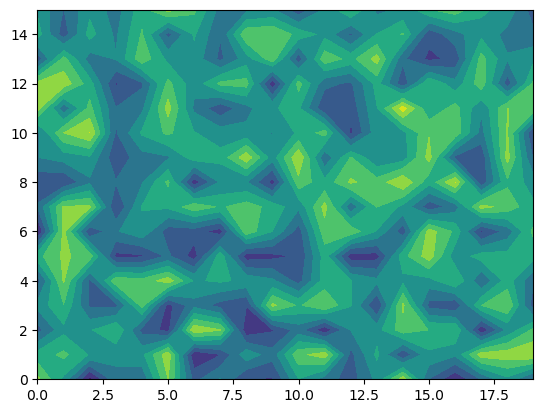

Range: -0.3412086167625598 -> 1.3448286321542562


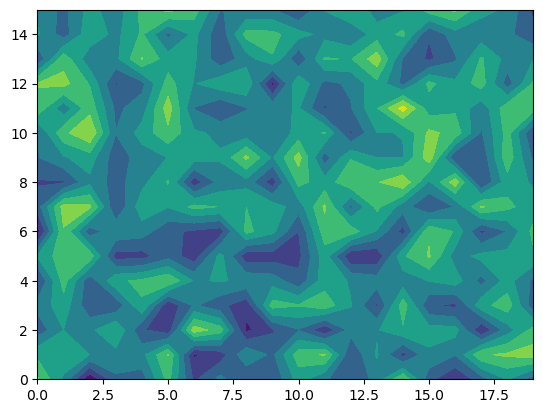

Range: -0.5550188969312626 -> 1.5965689754814683


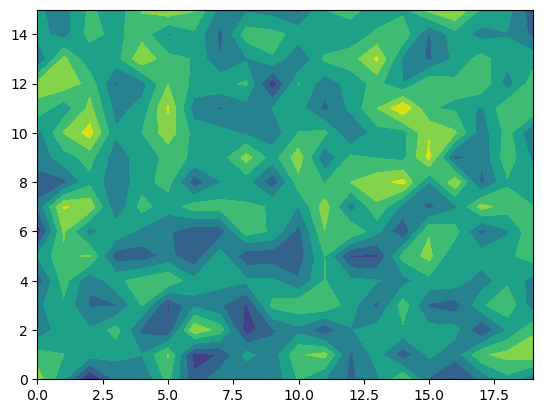

Range: -0.797059936263578 -> 1.884097326796641


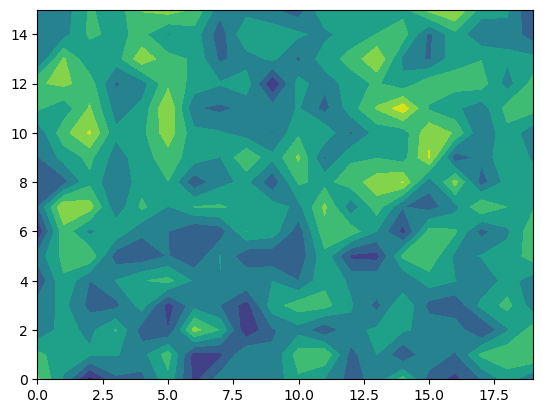

Range: -1.1978876570338515 -> 2.2163342078927886


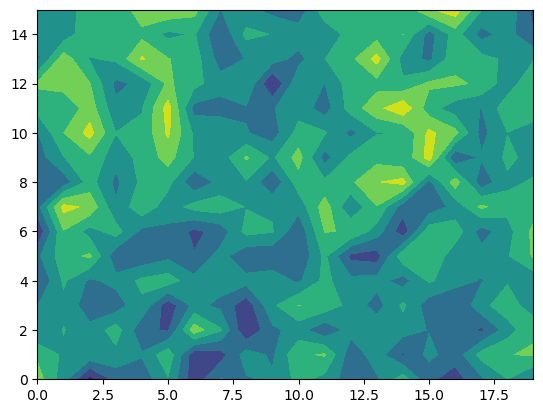

Range: -1.7193934278638987 -> 2.6052884680978194


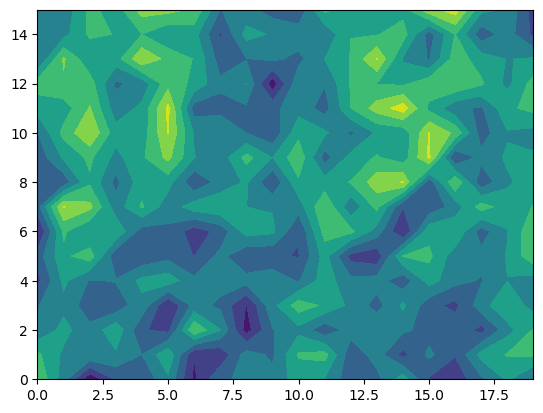

Range: -2.354734454855482 -> 3.125877823389454


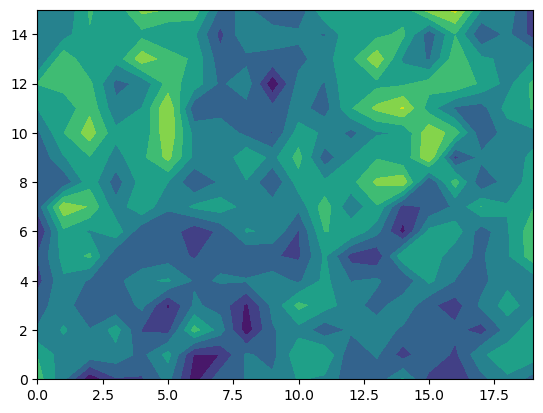

Range: -3.1361437126522524 -> 3.7746976752268044


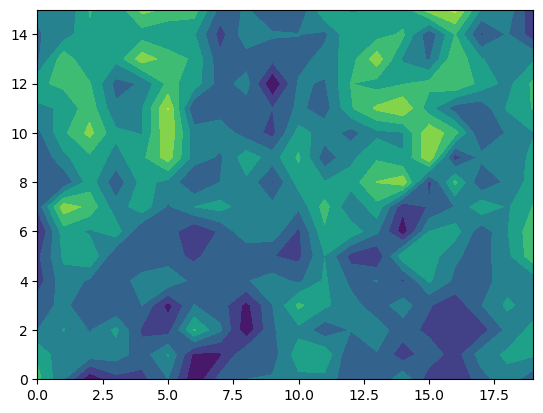

Range: -4.1039839013426125 -> 4.708179548413237


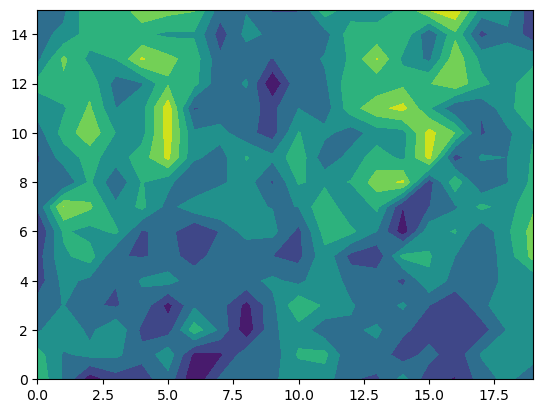

Range: -5.308964786286753 -> 5.876288881774398


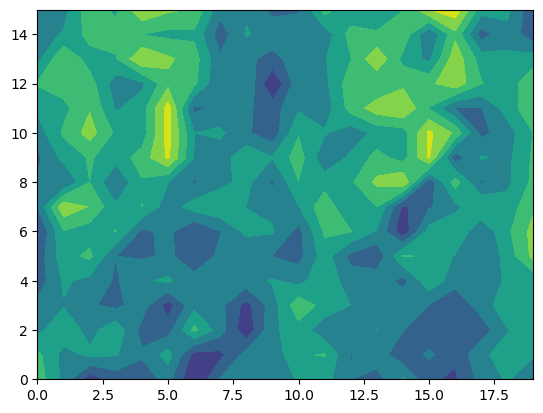

In [17]:
for i in range(10):
    # Take a step
    state = tf.linalg.lu_solve(lu, p, state)
    print(f"Range: {tf.math.reduce_min(state)} -> {tf.math.reduce_max(state)}")

    v = tf.gather(state, cell_number[2:-2,0,:])
    plt.contourf(v[:,:,0])
    plt.show()

In [18]:
state

<tf.Tensor: shape=(5120, 1), dtype=float64, numpy=
array([[ 2.56481233],
       [ 0.74504984],
       [-1.57839377],
       ...,
       [ 3.02962866],
       [ 2.22247382],
       [ 0.39829338]], shape=(5120, 1))>

In [19]:
tf.gather(state, cell_number[2:-2,0,:])

<tf.Tensor: shape=(16, 20, 1), dtype=float64, numpy=
array([[[ 2.56481233e+00],
        [ 7.45049841e-01],
        [-1.57839377e+00],
        [-5.94929023e-01],
        [-5.93503610e-01],
        [ 3.55290291e-01],
        [-2.04113101e+00],
        [ 5.22905484e-02],
        [ 8.18864627e-01],
        [ 7.49317760e-01],
        [ 1.03537449e+00],
        [ 1.37337561e+00],
        [ 2.81233458e-02],
        [-4.14850716e-01],
        [ 1.11949485e+00],
        [-8.72313886e-01],
        [-1.14025393e+00],
        [ 3.76843054e-01],
        [ 1.13435374e+00],
        [-1.71495269e-01]],

       [[ 2.25789816e+00],
        [ 6.54867584e-01],
        [ 1.17734891e+00],
        [ 1.08959857e+00],
        [ 1.34450881e-01],
        [ 1.43101042e+00],
        [-1.37287339e+00],
        [-1.29211850e+00],
        [ 4.05628272e-01],
        [ 3.18447888e-01],
        [ 1.92123528e+00],
        [ 2.05139363e+00],
        [-4.59145126e-02],
        [ 5.30928136e-01],
        [-6.68037500e-01],


# Parallel diffusion

Solving diffusion equation, e.g. for temperature or scalar field $f$

$$
\frac{\partial f}{\partial t} = \nabla\cdot\left(K\mathbf{b}\mathbf{b}\cdot\nabla f\right)
$$

Antisymmetric form for positive-definite quantities:
$$
\frac{\partial \sqrt{f}^2}{\partial t} = \sqrt{f}\left(\nabla\cdot\mathbf{b}v_K + v_K\mathbf{b}\cdot\nabla\right)\sqrt{f}
$$

$$
v_K = 2K\mathbf{b}\cdot\nabla\left(\log\sqrt{f}\right)
$$

Publication: F.Halpern et al. "Parallel diffusion operator for magnetized plasmas with improved spectral fidelity" arXiv:2412.01927



## Staggered parallel gradient

Maps from cell centered quantity to its gradient at 1/2 step forward along the magnetic field

## Staggered parallel divergence

Maps from flows at 1/2 step forward to their divergence at cell centers. Derived from the staggered parallel gradient

## Parallel interpolation

Operators that interpolate between cell center and 1/2 step forward.



In [78]:
# Create a parallel gradient operator that maps from cell center quantities to staggered 1/2 way in the forward direction

grad_par_f = tf.sparse.add(forward_op,
                           tf.sparse.eye(n_evolving, num_columns=n_total, dtype=tf.dtypes.float64) * -1)

# Add rows for the radial (X) and parallel (Y) boundaries
# to create a square n_total x n_total matrix
grad_par_f = tf.sparse.SparseTensor(tf.concat([grad_par_f.indices,
                                                # X boundaries unchanged - ones on the diagonal
                                                tf.tile(boundary_xinner[:, 0][...,tf.newaxis], multiples=[1,2]),
                                                tf.tile(boundary_xouter[:, 0][...,tf.newaxis], multiples=[1,2]),
                                                # Y forward boundaries one-sided differences
                                                tf.tile(boundary_yforward[:, 0][...,tf.newaxis], multiples=[1,2]),
                                                boundary_yforward,
                                                # Y backward boundaries
                                                tf.tile(boundary_ybackward[:, 0][...,tf.newaxis], multiples=[1,2]),
                                                boundary_ybackward,
                                               ], axis = 0),
                                     tf.concat([grad_par_f.values,
                                                # X boundaries unchanged - ones on the diagonal
                                                tf.ones( boundary_xinner.shape[0] + boundary_xouter.shape[0], dtype=tf.dtypes.float64 ),
                                                # Y forward boundaries
                                                tf.ones( boundary_yforward.shape[0], dtype=tf.dtypes.float64 ),    # +1 in forward boundary cell
                                                tf.negative(tf.ones( boundary_yforward.shape[0], dtype=tf.dtypes.float64 )), # -1 in center cell
                                                # Y backward boundaries
                                                tf.negative(tf.ones( boundary_ybackward.shape[0], dtype=tf.dtypes.float64 )),  # -1 in boundary cell
                                                tf.ones( boundary_ybackward.shape[0], dtype=tf.dtypes.float64 ) # +1 in center cell
                                               ], axis = 0),
                                     [n_total, n_total])
grad_par_f = tf.sparse.reorder(grad_par_f) # Correctly sort indices

# Composing operators

To write equations like

$$
\frac{\partial v}{\partial t} = - \partial_{||} f
$$
$$
\frac{\partial f}{\partial t} = - \nabla_{||} v
$$

wrap the variables ($f$, $v$) in `Field` types, and the operators in `Operator` types 




In [36]:
class Field:
    def __init__(self, name, tensor=None):
        self.name = name
        self.tensor = tensor

    def __neg__(self):
        print("negate")

class Operator:
    def __init__(self, tensor):
        self.tensor = tensor
    
    def __call__(self, other):
        if not isinstance(other, Field):
            raise ValueError("Operators can only multiply Fields")
        return Field(other.name, tensor)




In [37]:
Grad_par = Operator(grad_par_op)
f = Field("f")
-Grad_par(f)

negate


In [72]:
help(tf.sparse.eye)

Help on function sparse_eye in module tensorflow.python.ops.sparse_ops:

sparse_eye(num_rows, num_columns=None, dtype=tf.float32, name=None)
    Creates a two-dimensional sparse tensor with ones along the diagonal.
    
    Args:
      num_rows: Non-negative integer or `int32` scalar `tensor` giving the number
        of rows in the resulting matrix.
      num_columns: Optional non-negative integer or `int32` scalar `tensor` giving
        the number of columns in the resulting matrix. Defaults to `num_rows`.
      dtype: The type of element in the resulting `Tensor`.
      name: A name for this `Op`. Defaults to "eye".
    
    Returns:
      A `SparseTensor` of shape [num_rows, num_columns] with ones along the
      diagonal.

